<a href="https://colab.research.google.com/github/KarlX07/NLP-assignment/blob/main/NLP_Assign%5B%5B3%5D%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.7 MB/s eta 0:00:00


In [3]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/tmp/ipython-input-1716558179.py:42: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=dest)
100%|██████████| 50000/50000 [00:44<00:00, 1121.90it/s]


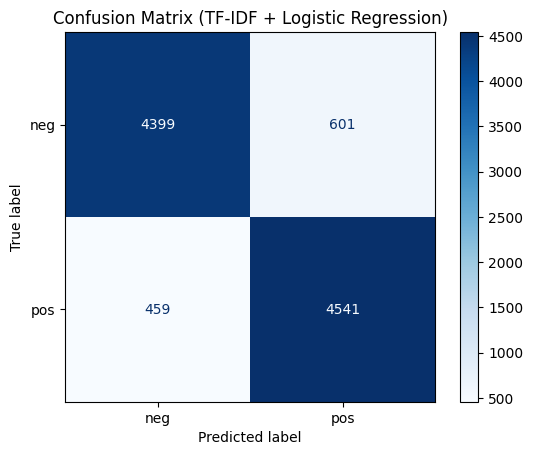

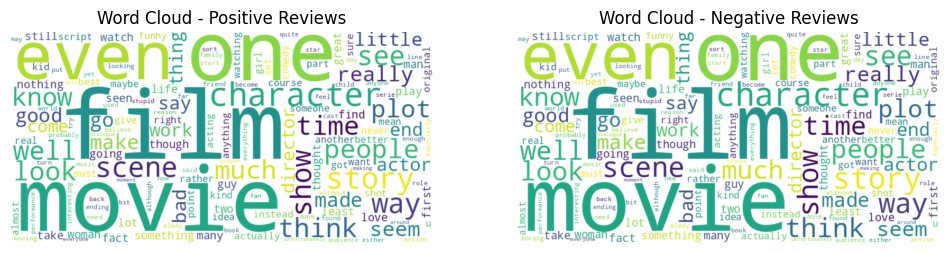


--- Example ---
True: 0 Pred: 1
movie billed three movie summary linked together form full length feature film including lot shot people slowly walking dark corridor street warned first hour movie simply hash first two aztec movie told main character actual movie start thing almost must say overacting part bat quite hilarious robot thought robot mechanical device may may resemble human bat robot consists radioactive reanimated corpse encased lead robot body tom servo put impressive even knee take robot hour lumber across room 

--- Example ---
True: 0 Pred: 1
brooke shield departure suddenly susan duty play bitter divorcee embroils three girlfriend girl weekend palm spring problem brooke unattached prowl friend involved hence title implication emotional backlash amoral weekend cause despite laugh generated dan cortese victoria closet mtv relationship authority adam corolla dr drew pinsky somber stuff woman b sweeney virginia madsen jon polito co star

--- Example ---
True: 1 Pred: 0
w

In [4]:

import os
import re
import tarfile
import urllib.request
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

nltk.download('stopwords')
nltk.download('wordnet')


def download_and_extract_imdb(dest_dir='data'):
    dest = Path(dest_dir)
    dest.mkdir(parents=True, exist_ok=True)
    url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    archive_path = dest / 'aclImdb_v1.tar.gz'
    if not (dest / 'aclImdb').exists():
        urllib.request.urlretrieve(url, archive_path)
        with tarfile.open(archive_path, 'r:gz') as tar:
            tar.extractall(path=dest)
    return dest / 'aclImdb'

imdb_root = download_and_extract_imdb('data')


def load_imdb_to_df(imdb_path: Path, subset=('train', 'test')):
    records = []
    for part in subset:
        for label in ['pos', 'neg']:
            folder = imdb_path / part / label
            for file in folder.iterdir():
                if file.suffix == '.txt':
                    text = file.read_text(encoding='utf-8', errors='ignore')
                    records.append({'text': text, 'label': 1 if label=='pos' else 0, 'split': part})
    df = pd.DataFrame(records)
    return df

df = load_imdb_to_df(imdb_root, subset=('train', 'test'))

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text: str, remove_stopwords=True):
    if not isinstance(text, str):
        return ''
    text = re.sub(r"<br \/>", ' ', text)
    text = re.sub(r"[^a-zA-Z0-9\\s]", ' ', text)
    text = text.lower()
    tokens = text.split()
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

cleaned = []
for txt in tqdm(df['text'].values, total=len(df)):
    cleaned.append(clean_text(txt))

df['clean'] = cleaned

X = df['clean'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

bow_vec = CountVectorizer(max_features=5000, ngram_range=(1,2))
tfidf_vec = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train_bow = bow_vec.fit_transform(X_train)
X_test_bow = bow_vec.transform(X_test)

X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf = tfidf_vec.transform(X_test)

clf = LogisticRegression(max_iter=300)
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','pos'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (TF-IDF + Logistic Regression)')
plt.show()

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
pos_text = ' '.join(train_df[train_df['label']==1]['text'].values)
neg_text = ' '.join(train_df[train_df['label']==0]['text'].values)

wc = WordCloud(width=800, height=400, background_color='white', max_words=150)
pos_wc = wc.generate(pos_text)
neg_wc = wc.generate(neg_text)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(pos_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Positive Reviews')

plt.subplot(1,2,2)
plt.imshow(neg_wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Negative Reviews')

plt.show()

mis_idx = np.where(y_pred != y_test)[0]

for i in mis_idx[:8]:
    print('\n--- Example ---')
    print('True:', y_test[i], 'Pred:', y_pred[i])
    print(X_test[i][:500].replace('\n', ' '))


def write_report_pdf(path='assignment3_report.pdf', metrics=None, notes=None):
    c = canvas.Canvas(path, pagesize=letter)
    width, height = letter
    margin = 50
    y = height - margin

    c.setFont('Helvetica-Bold', 16)
    c.drawString(margin, y, 'Assignment 3: Text Classification & Sentiment Analysis')
    y -= 30

    c.setFont('Helvetica', 11)
    c.drawString(margin, y, 'Author: (Your Name)')
    y -= 20

    c.setFont('Helvetica-Bold', 12)
    c.drawString(margin, y, 'Summary of Methods')
    y -= 16
    c.setFont('Helvetica', 10)
    summary_lines = [
        'Dataset: IMDB (aclImdb) raw text dataset with 50,000 reviews.',
        'Preprocessing: cleaning, stopword removal, lemmatization.',
        'Features: Bag-of-Words and TF-IDF (max 5000 features, unigrams+bigrams).',
        'Model: Logistic Regression trained on TF-IDF features.'
    ]
    for line in summary_lines:
        c.drawString(margin, y, '- ' + line)
        y -= 14

    y -= 6
    c.setFont('Helvetica-Bold', 12)
    c.drawString(margin, y, 'Results')
    y -= 16
    c.setFont('Helvetica', 10)
    if metrics:
        for k, v in metrics.items():
            c.drawString(margin, y, f'{k}: {v:.4f}')
            y -= 14

    y -= 8
    c.setFont('Helvetica-Bold', 12)
    c.drawString(margin, y, 'Challenges and Notes')
    y -= 16
    c.setFont('Helvetica', 10)
    if notes:
        for line in notes:
            wrapped = []
            while len(line) > 90:
                cut = line.rfind(' ', 0, 90)
                if cut == -1:
                    cut = 90
                wrapped.append(line[:cut])
                line = line[cut+1:]
            wrapped.append(line)
            for wline in wrapped:
                c.drawString(margin, y, wline)
                y -= 12
                if y < margin + 40:
                    c.showPage()
                    y = height - margin

    c.showPage()
    c.save()

metrics = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-score': f1}
notes = [
    'Misclassifications often caused by sarcasm, complex negation, and mixed sentiment in long reviews.',
    'TF-IDF + Logistic is a strong baseline but fails to capture contextual sarcasm; transformers recommended.',
    'Future work: use transformer fine-tuning, add sarcasm corpora, and explore ensemble methods.'
]

write_report_pdf('assignment3_report.pdf', metrics=metrics, notes=notes)

import joblib
os.makedirs('artifacts', exist_ok=True)
joblib.dump(clf, 'artifacts/logreg_tfidf_clf.joblib')
joblib.dump(tfidf_vec, 'artifacts/tfidf_vectorizer.joblib')
joblib.dump(bow_vec, 'artifacts/bow_vectorizer.joblib')

print('All done. assignment3_report.pdf created and artifacts saved.')